In [1]:
# https://docs.microsoft.com/en-us/learn/modules/automate-model-selection-with-azure-automl/4-automl-recommend-model
# https://notebooks.azure.com/azeltov/projects/MachineLearningNotebooks/html/automl/02.auto-ml-regression.ipynb
from azureml.core.workspace import Workspace

ws = Workspace.from_config()

In [2]:
ws.get_details()

{'applicationInsights': '/subscriptions/165934ca-a3be-4df3-842b-332997fcecd9/resourcegroups/myresourcegroup/providers/microsoft.insights/components/llachmanmlwork7726509491',
 'containerRegistry': '/subscriptions/165934ca-a3be-4df3-842b-332997fcecd9/resourceGroups/MyResourceGroup/providers/Microsoft.ContainerRegistry/registries/llachmanmlwo5de1ae17',
 'creationTime': '2019-08-10T02:16:58.7668266+00:00',
 'description': '',
 'friendlyName': '',
 'id': '/subscriptions/165934ca-a3be-4df3-842b-332997fcecd9/resourceGroups/MyResourceGroup/providers/Microsoft.MachineLearningServices/workspaces/llachmanMLWorkspace',
 'identityPrincipalId': '2166891c-3629-4f17-8f8e-72c1b4d8d9fb',
 'identityTenantId': 'c7970e8d-6d07-4b20-bf16-eba4864e56ef',
 'identityType': 'SystemAssigned',
 'keyVault': '/subscriptions/165934ca-a3be-4df3-842b-332997fcecd9/resourcegroups/myresourcegroup/providers/microsoft.keyvault/vaults/llachmanmlwork6145098727',
 'location': 'centralus',
 'name': 'llachmanMLWorkspace',
 'stor

## AutoML 02: Regression with Local Compute
In this example we use the scikit-learn's diabetes dataset to showcase how you can use AutoML for a simple regression problem.
http://scikit-learn.org/stable/datasets/index.html#diabetes-dataset

<ol>
<li>Create an Experiment in an existing Workspace.
<li>Configure AutoML using AutoMLConfig.
<li>Train the model using local compute.
<li>Explore the results.
<li>Test the best fitted model.
</ol>

In [3]:
import logging
import os
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

W0818 15:31:07.713342 140267988920064 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/automl/core/_vendor/automl/client/core/common/tf_wrappers.py:36: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0818 15:31:07.714707 140267988920064 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/automl/core/_vendor/automl/client/core/common/tf_wrappers.py:36: The name tf.logging.ERROR is deprecated. Please use tf.compat.v1.logging.ERROR instead.



In [4]:
# Choose a name for the experiment and specify the project folder
experiment_name = 'automl-regression'
project_folder = './automl-regression'

experiment = Experiment(workspace = ws, name = experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

,
SDK version,1.0.53
Subscription ID,165934ca-a3be-4df3-842b-332997fcecd9
Workspace Name,llachmanmlworkspace
Resource Group,myresourcegroup
Location,centralus
Project Directory,./automl-regression
Experiment Name,automl-regression


In [5]:
# Load the diabetes dataset, a well-known built-in small dataset that comes with scikit-learn.
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y = True)

columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Configure AutoML

| Property | Description |
|:---------|------------:|
| **task** | classification or regression |
| **iteration_timeout_minutes** | Time limit in seconds for each iteration |
| **iterations** | Number of iterations.  In each iteration AutoML trains a specific pipeline with the data |
| **primary_metric** | This is the metric that you want to optimize. Regression supports the following primary metrics:<br>spearman_correlation<br>normalized_root_mean_squared_error<br>r2_score<br>normalized_mean_absolute_error |
| **n_cross_validations** | Number of cross validation splits |
| **verbosity** | Verbosity level for log file |
| **X** | (sparse) array-like, shape = [n_samples, n_features] |
| **y** | (sparse) array-like, shape = [n_samples, ], [n_samples, n_classes]<br>Multi-class targets. An indicator matrix turns on multilabel classification. This should be an array of integers
| **path** | Relative path to the project folder. AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder |

In [6]:
from azureml.train.automl import AutoMLConfig
import logging

# Regression metrics include:  
# • normalized_root_mean_squared_error
# • r2_score
# • normalized_mean_absolute_error
# • spearman_correlation
# Local compute
automl_config = AutoMLConfig(task = 'regression',
                  iteration_timeout_minutes = 6,
                  iterations = 10,
                  primary_metric = 'spearman_correlation',
                  n_cross_validations = 5,
                  debug_log = 'automl.log',
                  verbosity = logging.INFO,
                  X = X_train,                  # not defined 
                  y = y_train,                  # not defined
                  path = project_folder)

In [7]:
# Train the models
local_run = experiment.submit(automl_config, show_output = True)
local_run

Running on local machine
Parent Run ID: AutoML_680c2f10-32ab-4cfe-9b0d-533428be4360
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   StandardScalerWrapper RandomForest             0:00:12       0.7034    0.7034
         1   MinMaxScaler RandomForest                      0:00:10       0.6553    0.7034
         2   StandardScalerWrapper ExtremeRandomTrees   

Experiment,Id,Type,Status,Details Page,Docs Page
automl-regression,AutoML_680c2f10-32ab-4cfe-9b0d-533428be4360,automl,Completed,Link to Azure Portal,Link to Documentation


In [8]:
from azureml.widgets import RunDetails

# The widget first reports a "loading" status while running the first iteration.  After completing the first iteration, an 
# auto-updating graph and table are shown. The widget refreshes once per minute, so the graph updates as child runs complete
RunDetails(local_run).show()

A Jupyter Widget

In [9]:
# Retrieve All Child Runs
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9
explained_variance,0.50,0.46,0.50,0.49,0.02,0.54,0.45,0.51,0.54,0.54
mean_absolute_error,45.98,47.23,46.94,46.27,61.13,43.64,46.07,45.67,43.97,44.42
mean_absolute_percentage_error,41.81,42.40,42.48,42.15,52.55,39.89,39.96,41.12,39.69,40.19
median_absolute_error,42.29,43.09,44.17,40.70,49.40,37.72,39.72,41.55,41.17,40.87
normalized_mean_absolute_error,0.14,0.15,0.15,0.14,0.19,0.14,0.14,0.14,0.14,0.14
normalized_median_absolute_error,0.13,0.13,0.14,0.13,0.15,0.12,0.12,0.13,0.13,0.13
normalized_root_mean_squared_error,0.17,0.18,0.17,0.18,0.24,0.17,0.18,0.17,0.17,0.17
normalized_root_mean_squared_log_error,0.17,0.17,0.17,0.17,0.23,0.16,0.17,0.17,0.16,0.16
r2_score,0.48,0.44,0.48,0.47,0.00,0.52,0.43,0.49,0.52,0.52
root_mean_squared_error,55.51,57.89,55.99,56.22,77.30,53.31,58.35,55.05,53.41,53.80


In [10]:
# Retrieve the best model.  The Model includes the pipeline and any pre-processing.  Overloads on get_output allow you to 
# retrieve the best run and fitted model for any logged metric or for a particular iteration
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: automl-regression,
Id: AutoML_680c2f10-32ab-4cfe-9b0d-533428be4360_8,
Type: None,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('prefittedsoftvotingregressor', PreFittedSoftVotingRegressor(estimators=[('5', RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7f91f84e2e80>), ('LassoLars', LassoLars(alpha=0.0...))],
               flatten_transform=None,
               weights=[0.3, 0.2, 0.1, 0.1, 0.1, 0.2]))]),
          stddev=None)


In [11]:
# Best Model Based on Any Other Metric
# Show the run and the model that has the smallest root_mean_squared_error value 
# (which turns out to be the same as the one with largest spearman_correlation value):
lookup_metric = "root_mean_squared_error"
best_run, fitted_model = local_run.get_output(metric = lookup_metric)
print(best_run)
print(fitted_model)

Run(Experiment: automl-regression,
Id: AutoML_680c2f10-32ab-4cfe-9b0d-533428be4360_5,
Type: None,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7f91f847ba58>), ('LassoLars', LassoLars(alpha=0.001, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
     positive=False, precompute='auto', verbose=False))]),
          stddev=None)


In [12]:
# Model from a Specific Iteration.  Show the run and the model from the third iteration:
iteration = 3
third_run, third_model = local_run.get_output(iteration = iteration)
print(third_run)
print(third_model)

Run(Experiment: automl-regression,
Id: AutoML_680c2f10-32ab-4cfe-9b0d-533428be4360_3,
Type: None,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7f91f847ba20>), ('LightGBMRegressor', LightGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
         importance_type='split', learning_rate=0.12631947368421054,
     ...ent=True,
         subsample=0.9, subsample_for_bin=200000, subsample_freq=3,
         verbose=-1))]),
          stddev=None)


In [13]:
# Test the best fitted model
y_pred_train = fitted_model.predict(X_train)
y_residual_train = y_train - y_pred_train

y_pred_test = fitted_model.predict(X_test)
y_residual_test = y_test - y_pred_test

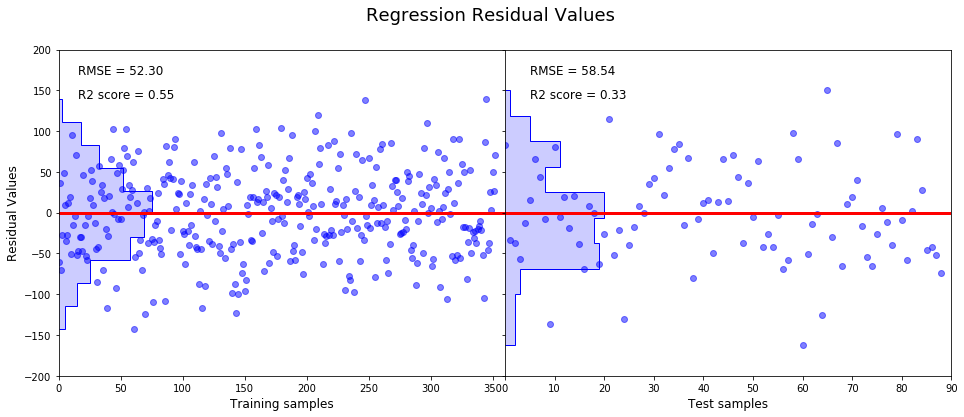

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score

# Set up a multi-plot chart.
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[1, 1], 'wspace':0, 'hspace': 0})
f.suptitle('Regression Residual Values', fontsize = 18)
f.set_figheight(6)
f.set_figwidth(16)

# Plot residual values of training set.
a0.axis([0, 360, -200, 200])
a0.plot(y_residual_train, 'bo', alpha = 0.5)
a0.plot([-10,360],[0,0], 'r-', lw = 3)
a0.text(16,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))), fontsize = 12)
a0.text(16,140,'R2 score = {0:.2f}'.format(r2_score(y_train, y_pred_train)), fontsize = 12)
a0.set_xlabel('Training samples', fontsize = 12)
a0.set_ylabel('Residual Values', fontsize = 12)

# Plot a histogram.
a0.hist(y_residual_train, orientation = 'horizontal', color = 'b', bins = 10, histtype = 'step');
a0.hist(y_residual_train, orientation = 'horizontal', color = 'b', alpha = 0.2, bins = 10);

# Plot residual values of test set.
a1.axis([0, 90, -200, 200])
a1.plot(y_residual_test, 'bo', alpha = 0.5)
a1.plot([-10,360],[0,0], 'r-', lw = 3)
a1.text(5,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))), fontsize = 12)
a1.text(5,140,'R2 score = {0:.2f}'.format(r2_score(y_test, y_pred_test)), fontsize = 12)
a1.set_xlabel('Test samples', fontsize = 12)
a1.set_yticklabels([])

# Plot a histogram.
a1.hist(y_residual_test, orientation = 'horizontal', color = 'b', bins = 10, histtype = 'step')
a1.hist(y_residual_test, orientation = 'horizontal', color = 'b', alpha = 0.2, bins = 10)

plt.show()

## Register and deploy the ML model with Azure Machine Learning service 
<b>Register the model</b> in a Machine Learning Model Registry hosted in Azure Machine Learning Service workspace
<b>Register an image</b> that pairs a model with an inference script and dependencies required to create a docker container providing the compute environment to run the pipeline.
<b>Monitor and collect data</b> about model training, performance, and deployments.
<ul>
    <li>Determine whether the production data drifts
    <li>Make better decisions on when to retrain or optimize your model
    <li>Track model usage statistics
</ul>

The model registry is a single place to keep track of all the models in your Azure Machine Learning Service workspace. 

In [16]:
# https://docs.microsoft.com/en-us/learn/modules/register-and-deploy-model-with-amls/4-register-model
from sklearn.externals import joblib

# Save the model as a pickle file in the outputs folder of the experiment workspace. The pickle file is used to deploy the 
# model.  The file saved in the outputs folder automatically uploads into the experiment record
joblib.dump(value = fitted_model, filename = './outputs/sklearn_regression_model.pkl')

['./outputs/sklearn_regression_model.pkl']

In [17]:
from azureml.core.model import Model
model = Model.register(model_path = "./outputs",
                       model_name = "sklearn_regression_model.pkl",
                       tags = {'area': "diabetes", 'type': "regression"},
                       description = "Ridge regression model to predict diabetes",
                       workspace = ws)

Registering model sklearn_regression_model.pkl


In [ ]:
%%writefile score.py

# Container images allow users to deploy models reliably since the machine learning model always depends on some other 
# dependencies such as PyTorch. Using containers to deploy machine learning models can avoid dependency issues.
# Prepare the following packaged items for # A container image has the following items packaged, which you need to prepare:
# • The model itself
# • The inference engine, such as PyTorch
# • The scoring file (score.py) or other application consuming the model
# • Any dependencies needed
#
# The first step is to create the scoring script, score.py, a file that consumes the model, and defines two functions: 
# init, which loads the model and run, which does the inference:
#
# The model scoring script is used to define the call parameters needed by the REST API. 

from sklearn.externals import joblib
from sklearn.linear_model import Ridge
from azureml.core.model import Model
import json

# Load the model
def init():
    global model
    model_path = Model.get_model_path('sklearn_regression_model.pkl')
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)
# note you can pass in multiple rows for scoring

# Perform the inference
def run(raw_data):
    try:
        data = json.loads(raw_data)['data']
        data = numpy.array(data)
        result = model.predict(data)
        # you can return any datatype if it is JSON-serializable
        return result.tolist()
    except Exception as e:
        error = str(e)
        return error

In [ ]:
# The second step is to create the environment YAML file, a conda dependency file that makes sure the dependencies 
# are included in the image
from azureml.core.conda_dependencies import CondaDependencies 
myenv = CondaDependencies.create(conda_packages=['numpy', 'scikit-learn'])
with open('myenv.yml', 'w') as f:
    f.write(myenv.serialize_to_string())

In [ ]:
# The third step is preparing the container image for the trained model using the Azure ML SDK to create the image
# After the code is executed, you can view the images in the Azure Machine Learning service portal
from azureml.core.image import Image, ContainerImage
image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script="score.py",
                                 conda_file="myenv.yml",
                                 tags = {'area': "diabetes", 'type': "regression"},
                                 description = "Image with ridge regression model")
image = Image.create(name = "myimage1",
                     # this is the model object 
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)
image.wait_for_creation(show_output = True)

## Where to deploy your model
https://docs.microsoft.com/en-us/learn/modules/register-and-deploy-model-with-amls/8-where-to-deploy-model
Once a model has been trained and you are ready to make it available to your applications and services, you need to deploy it
Deploying a model allows it to receive data from a client, process the data with the trained model, and return results back 
to the client.  AML Service provides several places you can deploy your trained model using the AML SDK, including:

| Location | Type | Description |
|----------|------|-------------|
| [Azure Container Instances (ACI)](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-and-where#aci) |	Testing	| Single container instance managed by Azure Container Instances service. Fast deployment speed (< 5 minutes) and is an ideal environment for development and testing |
| [Azure Kubernetes Service (AKS)](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-azure-kubernetes-service) | Real-time interface | Set of containers managed by Azure Kubernetes Service that provides high-scale production deployments, auto-scale, and a front end to handle ingress and egress requests. ~20 minutes to set up, but this is a one-time setup and is ideal for production deployment |
| [Azure Machine Learning Compute](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-and-where#azuremlcompute) | Batch interface | Run batch prediction on serverless compute. Supports normal and low-priority VMs created and managed by AML service |
| [Azure IoT Edge](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-and-where#iotedge) | IoT module |	Linux or Windows-based device that runs the Azure IoT Edge runtime. Once the model is deployed to IoT Edge devices, the model can be used in the edge device directly without connect to the cloud, which reduces the data transfer amount and reduces the response time |
| [Field-programmable gate array (FPGA)](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-and-where#fpga) | Web service | An array of programmable logic blocks, and a hierarchy of reconfigurable interconnects. Compared to CPU and GPUs, FPGAs provide a combination of programmability and performance. The hardware can be programmed so that it can provide model inference with hardware (much faster than software), and the hardware updates to a different set of models, which provides flexibility |

In [ ]:
# Now that we have an image that contains our trained model, use Azure Container Instances to deploy the trained model as a 
# web service. Two steps:
# • Define the deployment configuration, which defines the compute to be created to serve the model to scoring applications
#   The following code defines a container that uses 1 CPU and 1 GB of memory:
from azureml.core.webservice import AciWebservice
aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                          memory_gb = 1, 
                                          tags = {"data": "mnist", "type": "classification"}, 
                                          description = 'Handwriting recognition')

In [ ]:
# In a prior unit, you created an image and stored it in an object named image. To deploy the image:
from azureml.core.webservice import Webservice
service_name = 'aci-mnist-13'
service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                            image = image,
                                            name = service_name,
                                            workspace = ws)
service.wait_for_deployment(show_output = True)

# It takes ~3-4 minutes for the web service to deploy. Once it's deployed, we can call it from a client application.

## Score the data with the deployed model
Since the model is deployed as a web service that exposes a REST API, it can be tested with many tools. AML SDK has a built-in 
testing tool that can work with the deployed web service, like below.  The key part of the code is the service.run call, which 
sends a JSON formatted document to the deployed web service and the result is displayed.

In [ ]:
import json
test_sample = json.dumps({'data': [
    [1,2,3,4,5,6,7,8,9,10], 
    [10,9,8,7,6,5,4,3,2,1]
]})
test_sample = bytes(test_sample,encoding = 'utf8')
prediction = service.run(input_data = test_sample)
print(prediction)

## Remote Runs

In [ ]:
print(ws.compute_targets)

In [ ]:
# https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/remote-amlcompute/auto-ml-remote-amlcompute.ipynb

# Create or Attach existing AmlCompute
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

# Choose a name for your cluster.
amlcompute_cluster_name = "cpucluster"

found = False
# Ensure this compute target already exists in the workspace
cts = ws.compute_targets
if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].type == 'AmlCompute':
    found = True
    print('Found existing compute target', amlcompute_cluster_name)
    compute_target = cts[amlcompute_cluster_name]

if not found:
    print('Unable to find compute target attached to workspace...')

In [ ]:
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies
import pkg_resources

# create a new RunConfig object
conda_run_config = RunConfiguration(framework="python")

# Set compute target to AmlCompute
conda_run_config.target = compute_target
conda_run_config.environment.docker.enabled = True
conda_run_config.environment.docker.base_image = azureml.core.runconfig.DEFAULT_CPU_IMAGE

dprep_dependency = 'azureml-dataprep==' + pkg_resources.get_distribution("azureml-dataprep").version

cd = CondaDependencies.create(pip_packages=['azureml-sdk[automl]', dprep_dependency], conda_packages=['numpy','py-xgboost<=0.80'])
conda_run_config.environment.python.conda_dependencies = cd

## Train

Note: When using AmlCompute, you can't pass Numpy arrays directly to the fit method.

In [ ]:
automl_settings = {
    "iteration_timeout_minutes": 10,
    "iterations": 20,
    "n_cross_validations": 5,
    "primary_metric": 'AUC_weighted',
    "preprocess": False,
    "max_concurrent_iterations": 5,
    "verbosity": logging.INFO
}

automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             path = project_folder,
                             run_configuration=conda_run_config,
                             X = X,
                             y = y,
                             **automl_settings
                            )

In [ ]:
remote_run = experiment.submit(automl_config, show_output = False)
remote_run

In [ ]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

In [ ]:
# Wait until the run finishes
remote_run.wait_for_completion(show_output = True)

In [ ]:
# Retrieve All Child Runs
children = list(remote_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

In [ ]:
# You can cancel ongoing remote runs using the cancel and cancel_iteration functions.
# Cancel the ongoing experiment and stop scheduling new iterations.
# remote_run.cancel()

# Cancel iteration 1 and move onto iteration 2.
# remote_run.cancel_iteration(1)

## Retrieve the Best Model

In [ ]:
# get_output() returns the best run and the fitted model. The Model includes the pipeline and any pre-processing. 
# Overloads on get_output can also retrieve the best run and fitted model for any logged metric or for a particular iteration
best_run, fitted_model = remote_run.get_output()
print(best_run)
print(fitted_model)

In [ ]:
lookup_metric = "log_loss"
best_run, fitted_model = remote_run.get_output(metric = lookup_metric)
print(best_run)
print(fitted_model)

In [ ]:
iteration = 3
third_run, third_model = remote_run.get_output(iteration=iteration)
print(third_run)
print(third_model)

## Test

In [ ]:
digits = datasets.load_digits()
X_test = digits.data[:10, :]
y_test = digits.target[:10]
images = digits.images[:10]

In [ ]:
# Randomly select digits and test.
for index in np.random.choice(len(y_test), 2, replace = False):
    print(index)
    predicted = fitted_model.predict(X_test[index:index + 1])[0]
    label = y_test[index]
    title = "Label value = %d  Predicted value = %d " % (label, predicted)
    fig = plt.figure(1, figsize=(3,3))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(images[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
    plt.show()